In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score, recall_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Reading Dataset

In [ ]:
data = pd.read_parquet('/content/drive/MyDrive/IE/Capstone/transactions_dataset.parquet')

In [ ]:
data.head()

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id
0,2017-09-25,2017-09-25,2376333,188502,155.44320,3,online,2732
1,2017-09-25,2017-09-25,2520527,835089,16.39440,3,at the store,10279
2,2017-09-25,2017-09-25,2536756,1977896,365.76624,21,online,6184
3,2017-09-25,2017-09-25,3028673,598816,8.59878,201,at the store,4200
4,2017-09-25,2017-09-25,203377,2086861,1093.37400,3,by phone,7051


# Churn Exploration

In this section, we explore the definition of churn.

We came up with 5 approaches:
* Confidence interval
* K-means
* Confidence interval + K-means
* K-means + purchase interval
* Windows (applied solution)

## Confidence interval calculation

The primary concept behind using a confidence interval is to determine where the recency of each client's purchase falls on a normal distribution curve. If the purchase intervals of clients follow a normal distribution, we can calculate the position of the recency within this curve. When the recency lies beyond the right tail of the 95% confidence interval, it indicates that the likelihood of such a recency occurring is less than 2.5%. This suggests that the customer has most likely churned.

However, after conducting a normality test on the purchase behaviour of our customers, we found that it does not follow a normal distribution. As a result, we cannot apply this approach to assess customer churn accurately.

In [ ]:
df = pd.DataFrame(data)
df['date_order'] = pd.to_datetime(df['date_order'])

# keep 1 each day
df = df.drop_duplicates(subset=['client_id', 'date_order'])

# order by client_id and date_order
df = df.sort_values(by=['client_id', 'date_order'])

# calculate interval
df['purchase_interval'] = df.groupby('client_id')['date_order'].diff().dt.days

# delete null
purchase_intervals = df.dropna(subset=['purchase_interval'])

In [ ]:
purchase_intervals.head()

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id,purchase_interval
5772709,2017-11-29,2017-11-29,654297,6,87.216000,5,at the store,8470,33.0
16396119,2018-03-30,2018-03-30,2004688,6,265.502187,31,by phone,8470,121.0
19328851,2018-05-10,2018-05-10,1954776,6,550.216488,101,by phone,8470,41.0
36399679,2018-11-20,2018-11-20,169851,6,76.590000,5,at the store,8470,194.0
36928596,2018-11-22,2018-11-22,2900686,6,193.420800,3,at the store,8470,2.0


In [ ]:
# Function to check normality for individual customers
def check_customer_normality(df, client_id):
    customer_data = df[df['client_id'] == client_id]['purchase_interval']
    if len(customer_data) < 3:  # Shapiro-Wilk test requires at least 3 data points
        return np.nan, np.nan
    shapiro_test = stats.shapiro(customer_data)
    return shapiro_test.statistic, shapiro_test.pvalue

# Apply this function to each customer
results = []
for client in purchase_intervals['client_id'].unique():
    statistic, pvalue = check_customer_normality(purchase_intervals, client)
    results.append({'client_id': client, 'statistic': statistic, 'pvalue': pvalue})

results_df = pd.DataFrame(results)

# proportion
alpha = 0.05
results_df['is_normal'] = results_df['pvalue'].apply(lambda p: p > alpha)
normal_customers = results_df['is_normal'].sum()
total_customers = results_df['client_id'].nunique()
normal_ratio = normal_customers / total_customers

print(f"Number of customers following normal distribution: {normal_customers}")
print(f"Total number of customers: {total_customers}")
print(f"Proportion of customers following normal distribution: {normal_ratio:.2f}")

# result
print(results_df)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


Number of customers following normal distribution: 28807
Total number of customers: 149508
Proportion of customers following normal distribution: 0.19
        client_id  statistic        pvalue  is_normal
0               6   0.784674  6.305424e-03      False
1               7        NaN           NaN      False
2              14   0.508629  4.538706e-35      False
3              18   0.577126  5.487160e-26      False
4              37   0.666565  1.700066e-04      False
...           ...        ...           ...        ...
149503    2274440   0.707817  9.301566e-06      False
149504    2274456   0.629776  1.240724e-03      False
149505    2274479        NaN           NaN      False
149506    2274504        NaN           NaN      False
149507    2274517   0.949290  2.828537e-01       True

[149508 rows x 4 columns]


## K-means

K-means is able to cluster the customers according to their puchase behaviour, so by using k-means, we might be able to find a cluster that implies high probability of churn.

Though we did find a cluster with extremely high recency, the cluster also shows characteristics of low clv and low frequency, which means that those customers in the cluster are the ones that have purchased only once or twice, so we were not able to detect the churn of high value customers.

### Finding the best cluster number

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/IE/Capstone/client.csv')

In [ ]:
#reseting indexes
data=data.set_index('Unnamed: 0',drop=True)
data=data.reset_index(drop=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170589 entries, 0 to 170588
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   client_id                   170589 non-null  int64  
 1   first_purchase_date         170589 non-null  object 
 2   last_purchase_date          170589 non-null  object 
 3   last_invoice_date           170589 non-null  object 
 4   recency                     170589 non-null  int64  
 5   monetary                    170589 non-null  float64
 6   frequency                   170589 non-null  int64  
 7   avg_days_between_purchases  170589 non-null  float64
 8   most_common_order_channel   170589 non-null  object 
 9   returns                     170589 non-null  float64
 10  product_id                  170589 non-null  int64  
 11  unique_products             170589 non-null  int64  
 12  most_common_branch          170589 non-null  int64  
 13  total_quantity

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

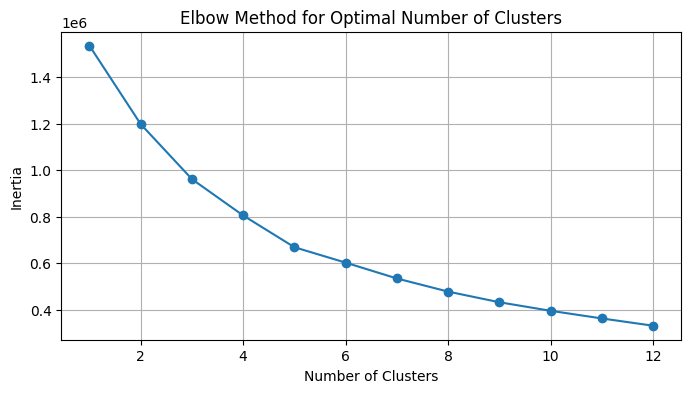

In [ ]:
df = pd.DataFrame(data)

# Select relevant columns
features = ['recency', 'frequency', 'monetary', 'avg_days_between_purchases', 'returns',
            'unique_products', 'total_quantity', 'purchase_interval_variance', 'lifespan']

# Handle missing values
df = df.dropna(subset=features)

# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])

### Step 3: K-means Clustering

# Determine the optimal number of clusters using the elbow method
inertia = []
range_n_clusters = range(1, 13)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 4))
plt.plot(range_n_clusters, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()

### Cluster Analysis

The clustering analysis is done in `Dataiku`, the following is just an example showing how the clusters might look like.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


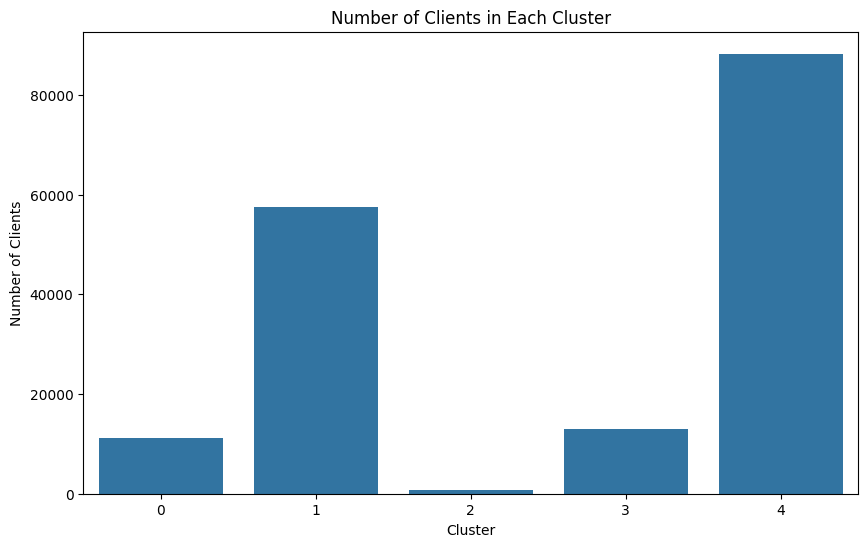

In [ ]:
# Fit K-means with the optimal number of clusters
optimal_n_clusters = 5
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=0)
df['cluster'] = kmeans.fit_predict(scaled_features)

### Step 4: Cluster Analysis

# Add cluster labels to the original DataFrame
df['cluster'] = kmeans.labels_

# Analyze clusters
cluster_summary = df.groupby('cluster')[features].mean()

# Check the number of clients in each cluster
cluster_counts = df['cluster'].value_counts()

# Plot cluster distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Clients')
plt.title('Number of Clients in Each Cluster')
plt.show()

## K-means + Confidence Interval

In order to detect the churn status of the customers with high value, we tried to **conduct the confidence interval within the high value clusters**. However, those clusters did not pass through the normality test and the approach was abandoned.

In [ ]:
clustered = pd.read_csv('/content/drive/MyDrive/IE/Capstone/client_correct_clustered.csv')

In [ ]:
clustered.head()

,col_0,client_id,first_purchase_date,last_purchase_date,last_invoice_date,recency,monetary,frequency,avg_days_between_purchases,most_common_order_channel,returns,product_id,unique_products,most_common_branch,total_quantity,purchase_interval_variance,lifespan,CLV,cluster_labels
0,0,6,2017-10-27,2019-08-13,2019-08-13,40,5.882233e+03,13,54.583333,by phone,0.0,169851,37,8470,3038,4467.537879,1.794521,3430.631096,cluster_3
1,1,7,2018-07-16,2018-12-24,2018-12-24,272,1.190777e+03,2,161.000000,at the store,0.0,121848,10,7453,99,0.000000,0.441096,70.032917,cluster_0
2,2,14,2017-09-25,2019-09-20,2019-10-25,2,3.103187e+06,505,1.438492,by phone,73.0,2512504,4898,10319,1392564,0.866985,1.986301,243907.811972,cluster_4
3,3,18,2017-09-26,2019-09-12,2020-07-09,10,2.194882e+05,291,2.468966,at the store,148.0,3000784,786,6654,72612,6.734328,1.961644,56336.450767,cluster_1
4,4,25,2018-10-10,2018-10-10,2018-10-10,347,3.745861e+02,1,0.000000,at the store,0.0,91564,4,2876,108,0.000000,0.000000,0.000000,cluster_0


In [ ]:
# cluster_0: tier_3; cluster_1: churned; cluster_2: tier_1; cluster_3: at_risk; cluster_4: tier_2
clustered['cluster_labels'].value_counts()

cluster_labels
cluster_3    96116
cluster_0    58441
cluster_1    12249
cluster_2     3159
cluster_4      624
Name: count, dtype: int64

#### Normality test

In [ ]:
data = pd.read_parquet('/content/drive/MyDrive/IE/Capstone/transactions_dataset.parquet')

In [ ]:
# Initialize a DataFrame with your data
df = data
df['date_order'] = pd.to_datetime(df['date_order'])

# Keep only one transaction per client per day
df = df.drop_duplicates(subset=['client_id', 'date_order'])

# Order by client_id and date_order
df = df.sort_values(by=['client_id', 'date_order'])

# Calculate purchase intervals
df['purchase_interval'] = df.groupby('client_id')['date_order'].diff().dt.days

# Delete rows with null purchase_interval
purchase_intervals = df.dropna(subset=['purchase_interval'])

# Merge with clustered DataFrame
clustered = pd.merge(purchase_intervals, clustered[['client_id', 'cluster_labels']], on='client_id')

# Ensure 'purchase_interval' column has no NaN values after merging
clustered = clustered.dropna(subset=['purchase_interval'])

# Function to check normality for individual customers
def check_customer_normality(df, client_id):
    customer_data = df[df['client_id'] == client_id]['purchase_interval'].dropna()
    if len(customer_data) < 3:  # Shapiro-Wilk test requires at least 3 data points
        return np.nan, np.nan
    shapiro_test = stats.shapiro(customer_data)
    return shapiro_test.statistic, shapiro_test.pvalue

# Initialize a list to hold results for all specified clusters
results = []

# List of clusters to analyze
clusters_to_analyze = ['cluster_1', 'cluster_3', 'cluster_4']

for cluster in clusters_to_analyze:
    # Filter the dataframe for the current cluster
    cluster_df = clustered[clustered['cluster_labels'] == cluster]

    # Apply normality test to each customer in the current cluster
    for client in cluster_df['client_id'].unique():
        statistic, pvalue = check_customer_normality(cluster_df, client)
        results.append({'client_id': client, 'cluster_label': cluster, 'statistic': statistic, 'pvalue': pvalue})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Calculate the proportion of customers following a normal distribution for each cluster
alpha = 0.05
results_df['is_normal'] = results_df['pvalue'].apply(lambda p: p > alpha)

# Proportion of normal customers per cluster
for cluster in clusters_to_analyze:
    cluster_results = results_df[results_df['cluster_label'] == cluster]
    normal_customers = cluster_results['is_normal'].sum()
    total_customers = cluster_results['client_id'].nunique()
    normal_ratio = normal_customers / total_customers if total_customers > 0 else 0
    print(f"Cluster {cluster} - Number of customers following normal distribution: {normal_customers}")
    print(f"Cluster {cluster} - Total number of customers: {total_customers}")
    print(f"Cluster {cluster} - Proportion of customers following normal distribution: {normal_ratio:.2f}")

# Print overall result
print(results_df)


Cluster cluster_1 - Number of customers following normal distribution: 3
Cluster cluster_1 - Total number of customers: 12249
Cluster cluster_1 - Proportion of customers following normal distribution: 0.00
Cluster cluster_3 - Number of customers following normal distribution: 17690
Cluster cluster_3 - Total number of customers: 96116
Cluster cluster_3 - Proportion of customers following normal distribution: 0.18
Cluster cluster_4 - Number of customers following normal distribution: 1
Cluster cluster_4 - Total number of customers: 624
Cluster cluster_4 - Proportion of customers following normal distribution: 0.00
        client_id cluster_label  statistic        pvalue  is_normal
0              18     cluster_1   0.577126  5.487160e-26      False
1             252     cluster_1   0.579301  4.267515e-25      False
2             259     cluster_1   0.771780  2.619633e-14      False
3             753     cluster_1   0.759748  4.908052e-20      False
4             991     cluster_1   0.7927

## K-means + Average purchasing days

Knowing that confidence interval is not available in this case, we tried defining churn with K-means and average purchasing days.

The approach is as follows:
- apply churned for customers belonging to the cluster with extremely high recency and CLV.
- apply churned for customers that recency is 3 times larger than their average purchasing day.

This approach is able to customise the definition of churn according to different customers and also consider the customer value.

In [ ]:
clustered = pd.read_csv('/content/drive/MyDrive/IE/Capstone/client_correct_clustered.csv')

In [ ]:
clustered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170589 entries, 0 to 170588
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   col_0                       170589 non-null  int64  
 1   client_id                   170589 non-null  int64  
 2   first_purchase_date         170589 non-null  object 
 3   last_purchase_date          170589 non-null  object 
 4   last_invoice_date           170589 non-null  object 
 5   recency                     170589 non-null  int64  
 6   monetary                    170589 non-null  float64
 7   frequency                   170589 non-null  int64  
 8   avg_days_between_purchases  170589 non-null  float64
 9   most_common_order_channel   170589 non-null  object 
 10  returns                     170589 non-null  float64
 11  product_id                  170589 non-null  int64  
 12  unique_products             170589 non-null  int64  
 13  most_common_br

In [ ]:
# Set a threshold multiplier. If recency exceeds 3 times the average purchase interval, the customer is at risk of churn
threshold_multiplier = 3

# Define churn risk
clustered['churn_risk'] = clustered['recency'] > (threshold_multiplier * clustered['avg_days_between_purchases'])

# Print results
print(clustered[['client_id', 'recency', 'avg_days_between_purchases', 'churn_risk']])

# Count the number of customers at risk of churn
churn_customers = clustered['churn_risk'].sum()
total_customers = clustered['client_id'].nunique()
churn_ratio = churn_customers / total_customers

print(f"Number of customers at risk of churn: {churn_customers}")
print(f"Total number of customers: {total_customers}")
print(f"Proportion of customers at risk of churn: {churn_ratio:.2f}")


        client_id  recency  avg_days_between_purchases  churn_risk
0               6       40                   54.583333       False
1               7      272                  161.000000       False
2              14        2                    1.438492       False
3              18       10                    2.468966        True
4              25      347                    0.000000        True
...           ...      ...                         ...         ...
170584    2274456       20                    1.750000        True
170585    2274479      207                  485.000000       False
170586    2274504      264                  425.000000       False
170587    2274508      704                    0.000000        True
170588    2274517       24                   30.260870       False

[170589 rows x 4 columns]
Number of customers at risk of churn: 65706
Total number of customers: 170589
Proportion of customers at risk of churn: 0.39


In [ ]:
# Create the 'churn' column based on the condition
clustered.loc[clustered['cluster_labels']=='cluster_0','churn_risk'] = True

clustered.reset_index(drop=True,inplace=True)
clustered.head()

# Count the number of customers at risk of churn
churn_customers = clustered['churn_risk'].sum()
total_customers = clustered['client_id'].nunique()
churn_ratio = churn_customers / total_customers

print(f"Number of customers at risk of churn: {churn_customers}")
print(f"Total number of customers: {total_customers}")
print(f"Proportion of customers at risk of churn: {churn_ratio:.2f}")

Number of customers at risk of churn: 74635
Total number of customers: 170589
Proportion of customers at risk of churn: 0.44


In [ ]:
clustered[clustered['cluster_labels']=='cluster_1']

,col_0,client_id,first_purchase_date,last_purchase_date,last_invoice_date,recency,monetary,frequency,avg_days_between_purchases,most_common_order_channel,returns,product_id,unique_products,most_common_branch,total_quantity,purchase_interval_variance,lifespan,CLV,cluster_labels,churn_risk
3,3,18,2017-09-26,2019-09-12,2020-07-09,10,219488.170605,291,2.468966,at the store,148.0,3000784,786,6654,72612,6.734328,1.961644,56336.450767,cluster_1,True
27,27,252,2017-09-26,2019-09-18,2019-10-17,4,188261.560957,271,2.674074,at the store,20.0,1696760,494,7136,178457,7.038359,1.978082,39010.260512,cluster_1,False
28,28,259,2017-09-25,2019-09-19,2019-12-27,3,200736.514144,157,4.641026,by phone,27.0,2512504,371,6179,157013,19.844500,1.983562,58587.816538,cluster_1,False
50,50,753,2017-09-28,2019-09-19,2019-11-05,3,997376.082680,284,2.547703,by phone,14.0,2512504,1674,364,1723190,4.213142,1.975342,110490.768137,cluster_1,False
71,71,991,2017-09-25,2019-09-06,2019-11-18,16,413075.240103,215,3.322430,by phone,9.0,3219368,513,1888,223454,6.942499,1.947945,175100.511836,cluster_1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170538,170538,2273941,2017-09-28,2019-09-18,2019-10-01,4,364601.367769,185,3.913043,by phone,2.0,1895362,642,7560,73238,7.478736,1.972603,118586.922049,cluster_1,False
170539,170539,2273952,2017-09-26,2019-09-19,2019-09-30,3,160896.486127,271,2.677778,at the store,92.0,1366829,839,9904,56352,5.527757,1.980822,48576.869834,cluster_1,False
170552,170552,2274084,2017-09-25,2019-09-19,2020-06-17,3,441841.722146,265,2.742424,at the store,110.0,3000784,916,2255,122739,5.781311,1.983562,120901.289726,cluster_1,False
170562,170562,2274190,2017-09-27,2019-09-20,2020-09-17,2,338787.852845,451,1.606667,at the store,437.0,1366829,1734,5122,140623,1.272561,1.980822,53748.243720,cluster_1,False


In [ ]:
churn_customers = clustered.loc[clustered['cluster_labels']=='cluster_4','churn_risk'].sum()
total_customers = clustered[clustered['cluster_labels']=='cluster_4']['client_id'].count()
churn_ratio = churn_customers / total_customers
print(f"Number of customers at risk of churn: {churn_customers}")
print(f"Total number of customers: {total_customers}")
print(f"Proportion of customers at risk of churn: {churn_ratio:.2f}")


Number of customers at risk of churn: 88
Total number of customers: 624
Proportion of customers at risk of churn: 0.14


## Windows approach

Though the K-means + average purchasing days approach can define churn differently according to the customer purchase behaviour, it is possible to cause data leakage when training a model. Therefore, we decided to use the window approach for the model.

The idea is seperating the dataset into different windows, we used 2 months as the time period in this case. Then we assign the value of 1, if the customer has purchased during the 2 months, and 0, if the has not purchased. We obtained a new dataframe containing the customer behaviour and we're going to use it for prediction.


In [ ]:
# reading the dataset
data = pd.read_parquet('/content/drive/MyDrive/IE/Capstone/transactions_dataset.parquet')

# datetime
data['date_order'] = pd.to_datetime(data['date_order'])

# dataset for frequency calculation
data_unique = data.drop_duplicates(subset=['client_id', 'date_order'])

# generate 2-month window, starting from 0
min_date = data_unique['date_order'].min()
data_unique['window'] = ((data_unique['date_order'].dt.year - min_date.year) * 6 +
                         (data_unique['date_order'].dt.month - min_date.month) // 2)

# generate client_behaviour
client_behaviour = data_unique.groupby(['client_id', 'window']).size().unstack(fill_value=0)

<ipython-input-41-70f073eb0c5c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_unique['window'] = ((data_unique['date_order'].dt.year - min_date.year) * 6 +


In [ ]:
client_behaviour.columns = [0,1,2,3,4,5,6,7,8,9,10,11,12]
# define purchase behaviour
def process_window_12(value):
    return 0 if value == 0 else 1

# assign values to each of the columns
for column in client_behaviour.columns:
    client_behaviour[column] = client_behaviour[column].apply(process_window_12)
client_behaviour.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
client_id,,,,,,,,,,,,,
6,1,1,0,1,1,0,0,1,1,0,0,1,0
7,0,0,0,0,0,1,0,1,0,0,0,0,0
14,1,1,1,1,1,1,1,1,1,1,1,1,1
18,1,1,1,1,1,1,1,1,1,1,1,1,1
25,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
client_behaviour[12].value_counts()

12
0    110667
1     59922
Name: count, dtype: int64

In [ ]:
client_behaviour = pd.read_csv( '/content/drive/MyDrive/IE/Capstone/client_behaviour.csv', index_col=0)

# Churn Prediction Model

To decrease the churn rate of the customers and increase customer lifetime value, we developed a churn model based on the window dataset that we generated for customer behaviour analysis.

We tried 2 approaches:
- We created a dataset without the transactions happening in the lastest 30 days, and generated a client dataset based on it. The churn status is calculated in both datasets (with and without the latest 30 days transactions), and we tried to predict the changes of churn status.
- We used the purchased-or-not window dataset to predict whether a customer is going to purchase or not in the next two months.

## First Approach - based on client dataset

As mentioned,in the first approach, we tried using a client dataset without the transactions happening in the latest 30 days. Though without the 30 days of transactions, the RFM, CLV and other values will change accordingly and prevent data leakage, the definition of churn here is rather robust and hard to change over time, which results in the merely 18% of the changes of status during the one month period.

Additionally, using a summary of the whole history for prediction is not actually tracking customer behaviour evolution, for which we developed the second approach.

### Dataset without latest 30 days' transactions

In [ ]:
# Converting datetime format
data = pd.read_parquet('/content/drive/MyDrive/IE/Capstone/transactions_dataset.parquet')
data['date_order'] = pd.to_datetime(data['date_order'])
data['date_invoice'] = pd.to_datetime(data['date_invoice'])

# Determine the latest date in the data
latest_date_order = data['date_order'].max()

# Calculate the cutoff date
cutoff_date = latest_date_order - pd.Timedelta(days=30)

# Filter the data to exclude transactions from the last 30 days
data = data[data['date_order'] < cutoff_date]

# Display the filtered data
print(data.head())

# Save the filtered dataset if needed
# filtered_data.to_parquet('/path/to/save/filtered_data.parquet')


  date_order date_invoice  product_id  client_id   sales_net  quantity  \
0 2017-09-25   2017-09-25     2376333     188502   155.44320         3   
1 2017-09-25   2017-09-25     2520527     835089    16.39440         3   
2 2017-09-25   2017-09-25     2536756    1977896   365.76624        21   
3 2017-09-25   2017-09-25     3028673     598816     8.59878       201   
4 2017-09-25   2017-09-25      203377    2086861  1093.37400         3   

  order_channel  branch_id  
0        online       2732  
1  at the store      10279  
2        online       6184  
3  at the store       4200  
4      by phone       7051  


### Client profile for prediction

In [ ]:
# Latest date in the dataset
latest_date = data['date_order'].max()

# Drop duplicate transactions per customer per day
unique_transactions = data.drop_duplicates(subset=['client_id', 'date_order'])

# Aggregate the data to calculate RFM metrics
rfm = data.groupby('client_id').agg({
    'date_order': lambda x: (latest_date - x.max()).days,
    'sales_net': 'sum'
}).reset_index()

# Calculate frequency from unique_transactions
frequency = unique_transactions.groupby('client_id')['date_order'].count()

# Merge frequency into the RFM dataframe
rfm = rfm.merge(frequency, on='client_id')

# Rename columns for clarity
rfm = rfm.rename(columns={
    'date_order': 'recency',
    'sales_net': 'monetary'
})
df = data.drop_duplicates(subset=['client_id', 'date_order'])
df = df.sort_values(by=['client_id', 'date_order'])

# calculate interval
df['purchase_interval'] = df.groupby('client_id')['date_order'].diff().dt.days
avg_days_between_purchases = df.groupby('client_id')['purchase_interval'].mean().reset_index(name='avg_days_between_purchases')
variance_df = df.groupby('client_id')['purchase_interval'].var().reset_index(name='purchase_interval_variance')
variance_df['purchase_interval_variance'] = variance_df['purchase_interval_variance'].fillna(0)

# Replace NaN with 0 for customers with only one purchase
most_common_channel = data.groupby('client_id')['order_channel'].agg(lambda x: x.mode()[0]).reset_index(name='most_common_order_channel')

# Most Common Order Channel
most_common_channel = data.groupby('client_id')['order_channel'].agg(lambda x: x.mode()[0]).reset_index(name='most_common_order_channel')

# Number of returns
returns = data[data['sales_net'] < 0].groupby('client_id').size().reset_index(name='returns')
returns['returns'] = returns['returns'].fillna(0)

# Most Purchased Product
most_purchased_product = data.groupby(['client_id', 'product_id']).size().reset_index(name='count')
most_purchased_product = most_purchased_product.loc[most_purchased_product.groupby('client_id')['count'].idxmax()].drop(columns='count')

# Number of Unique Products Purchased
unique_products = data.groupby('client_id')['product_id'].nunique().reset_index(name='unique_products')

# Brach
most_common_branch = data.groupby('client_id')['branch_id'].agg(lambda x: x.mode()[0]).reset_index(name='most_common_branch')

# total quantity
total_quantity = data.groupby('client_id')['quantity'].sum().reset_index(name='total_quantity')

# First Purchase date
first_purchase_date = data.groupby('client_id')['date_order'].min().reset_index(name='first_purchase_date')

last_purchase_date = data.groupby('client_id')['date_order'].max().reset_index(name='last_purchase_date')
last_invoice_date = data.groupby('client_id')['date_invoice'].max().reset_index(name='last_invoice_date')
#CLV
# value
avg_purchase_value = data.groupby('client_id')['sales_net'].mean()
# lifespan
customer_lifespan = (data.groupby('client_id')['date_order'].max() - data.groupby('client_id')['date_order'].min()).dt.days / 365
# calculation
clv = avg_purchase_value * frequency * customer_lifespan

clv_df = pd.DataFrame({'client_id': clv.index, 'CLV': clv.values})
print(clv_df.head())
final_df = first_purchase_date \
    .merge(last_purchase_date, on='client_id') \
    .merge(last_invoice_date, on='client_id')\
    .merge(rfm, on='client_id') \
    .merge(avg_days_between_purchases, on='client_id') \
    .merge(most_common_channel, on='client_id') \
    .merge(returns, on='client_id', how='left') \
    .merge(most_purchased_product, on='client_id') \
    .merge(unique_products, on='client_id') \
    .merge(most_common_branch, on='client_id') \
    .merge(total_quantity, on='client_id') \
    .merge(variance_df, on='client_id')\
    .merge(customer_lifespan, on='client_id')\
    .merge(clv_df, on='client_id')

final_df=final_df.rename(columns={'date_order':'lifespan','date_order_x':'recency','date_order_y':'frequency'})
# Fill NA values in returns with 0
final_df['returns'] = final_df['returns'].fillna(0)
final_df['avg_days_between_purchases'] = final_df['avg_days_between_purchases'].fillna(0)

# Display the final DataFrame
final_df.head()

final_df.to_csv('/content/drive/MyDrive/IE/Capstone/client_prediction.csv')

   client_id            CLV
0          6    3430.631096
1          7      70.032917
2         14  226081.459668
3         18   50317.885099
4         25       0.000000


### Feature engineering

In [ ]:
final_df = pd.read_csv('/content/drive/MyDrive/IE/Capstone/client_prediction.csv')
clustered = pd.read_csv('/content/drive/MyDrive/IE/Capstone/client_correct_clustered.csv')

In [ ]:
clustered.head()

,col_0,client_id,first_purchase_date,last_purchase_date,last_invoice_date,recency,monetary,frequency,avg_days_between_purchases,most_common_order_channel,returns,product_id,unique_products,most_common_branch,total_quantity,purchase_interval_variance,lifespan,CLV,cluster_labels
0,0,6,2017-10-27,2019-08-13,2019-08-13,40,5.882233e+03,13,54.583333,by phone,0.0,169851,37,8470,3038,4467.537879,1.794521,3430.631096,cluster_3
1,1,7,2018-07-16,2018-12-24,2018-12-24,272,1.190777e+03,2,161.000000,at the store,0.0,121848,10,7453,99,0.000000,0.441096,70.032917,cluster_0
2,2,14,2017-09-25,2019-09-20,2019-10-25,2,3.103187e+06,505,1.438492,by phone,73.0,2512504,4898,10319,1392564,0.866985,1.986301,243907.811972,cluster_4
3,3,18,2017-09-26,2019-09-12,2020-07-09,10,2.194882e+05,291,2.468966,at the store,148.0,3000784,786,6654,72612,6.734328,1.961644,56336.450767,cluster_1
4,4,25,2018-10-10,2018-10-10,2018-10-10,347,3.745861e+02,1,0.000000,at the store,0.0,91564,4,2876,108,0.000000,0.000000,0.000000,cluster_0


In [ ]:
final_df = final_df.merge(clustered[['client_id','cluster_labels']],on='client_id')

In [ ]:
# Set a threshold multiplier. If recency exceeds 3 times the average purchase interval, the customer is at risk of churn
threshold_multiplier = 3

# Define churn risk
final_df['churn_risk'] = final_df['recency'] > (threshold_multiplier * final_df['avg_days_between_purchases'])

# Print results
print(final_df[['client_id', 'recency', 'avg_days_between_purchases', 'churn_risk']])

# Count the number of customers at risk of churn
churn_customers = final_df['churn_risk'].sum()
total_customers = final_df['client_id'].nunique()
churn_ratio = churn_customers / total_customers

print(f"Number of customers at risk of churn: {churn_customers}")
print(f"Total number of customers: {total_customers}")
print(f"Proportion of customers at risk of churn: {churn_ratio:.2f}")


        client_id  recency  avg_days_between_purchases  churn_risk
0               6        9                   54.583333       False
1               7      241                  161.000000       False
2              14        0                    1.435052       False
3              18        0                    2.491039       False
4              25      316                    0.000000        True
...           ...      ...                         ...         ...
168802    2274440        0                   30.130435       False
168803    2274479      176                  485.000000       False
168804    2274504      233                  425.000000       False
168805    2274508      673                    0.000000        True
168806    2274517       13                   30.727273       False

[168807 rows x 4 columns]
Number of customers at risk of churn: 58786
Total number of customers: 168807
Proportion of customers at risk of churn: 0.35


In [ ]:
# Set a threshold multiplier. If recency exceeds 3 times the average purchase interval, the customer is at risk of churn
threshold_multiplier = 3

# Define churn risk
clustered['churn_risk'] = clustered['recency'] > (threshold_multiplier * clustered['avg_days_between_purchases'])

# Print results
print(clustered[['client_id', 'recency', 'avg_days_between_purchases', 'churn_risk']])

# Count the number of customers at risk of churn
churn_customers = clustered['churn_risk'].sum()
total_customers = clustered['client_id'].nunique()
churn_ratio = churn_customers / total_customers

print(f"Number of customers at risk of churn: {churn_customers}")
print(f"Total number of customers: {total_customers}")
print(f"Proportion of customers at risk of churn: {churn_ratio:.2f}")

        client_id  recency  avg_days_between_purchases  churn_risk
0               6       40                   54.583333       False
1               7      272                  161.000000       False
2              14        2                    1.438492       False
3              18       10                    2.468966        True
4              25      347                    0.000000        True
...           ...      ...                         ...         ...
170584    2274456       20                    1.750000        True
170585    2274479      207                  485.000000       False
170586    2274504      264                  425.000000       False
170587    2274508      704                    0.000000        True
170588    2274517       24                   30.260870       False

[170589 rows x 4 columns]
Number of customers at risk of churn: 65706
Total number of customers: 170589
Proportion of customers at risk of churn: 0.39


In [ ]:
final_df.head()

,Unnamed: 0,client_id,first_purchase_date,last_purchase_date,last_invoice_date,recency,monetary,frequency,avg_days_between_purchases,most_common_order_channel,returns,product_id,unique_products,most_common_branch,total_quantity,purchase_interval_variance,lifespan,CLV,cluster_labels,churn_risk
0,0,6,2017-10-27,2019-08-13,2019-08-13,9,5.882233e+03,13,54.583333,by phone,0.0,169851,37,8470,3038,4467.537879,1.794521,3430.631096,cluster_3,False
1,1,7,2018-07-16,2018-12-24,2018-12-24,241,1.190777e+03,2,161.000000,at the store,0.0,121848,10,7453,99,0.000000,0.441096,70.032917,cluster_0,False
2,2,14,2017-09-25,2019-08-22,2019-10-25,0,3.009691e+06,486,1.435052,by phone,73.0,2512504,4753,10319,1357169,0.853728,1.906849,226081.459668,cluster_4,False
3,3,18,2017-09-26,2019-08-22,2020-07-09,0,2.028191e+05,280,2.491039,at the store,146.0,3000784,759,6654,70893,6.934272,1.904110,50317.885099,cluster_1,False
4,4,25,2018-10-10,2018-10-10,2018-10-10,316,3.745861e+02,1,0.000000,at the store,0.0,91564,4,2876,108,0.000000,0.000000,0.000000,cluster_0,True


In [ ]:
# Adding the result after 30 days
final_df = final_df.merge(clustered[['client_id','churn_risk']],on='client_id')
final_df.rename(columns={'churn_risk_y':'churn_result','churn_risk_x':'churn_status'},inplace=True)

In [ ]:
final_df.head()

,Unnamed: 0,client_id,first_purchase_date,last_purchase_date,last_invoice_date,recency,monetary,frequency,avg_days_between_purchases,most_common_order_channel,...,product_id,unique_products,most_common_branch,total_quantity,purchase_interval_variance,lifespan,CLV,cluster_labels,churn_status,churn_result
0,0,6,2017-10-27,2019-08-13,2019-08-13,9,5.882233e+03,13,54.583333,by phone,...,169851,37,8470,3038,4467.537879,1.794521,3430.631096,cluster_3,False,False
1,1,7,2018-07-16,2018-12-24,2018-12-24,241,1.190777e+03,2,161.000000,at the store,...,121848,10,7453,99,0.000000,0.441096,70.032917,cluster_0,False,False
2,2,14,2017-09-25,2019-08-22,2019-10-25,0,3.009691e+06,486,1.435052,by phone,...,2512504,4753,10319,1357169,0.853728,1.906849,226081.459668,cluster_4,False,False
3,3,18,2017-09-26,2019-08-22,2020-07-09,0,2.028191e+05,280,2.491039,at the store,...,3000784,759,6654,70893,6.934272,1.904110,50317.885099,cluster_1,False,True
4,4,25,2018-10-10,2018-10-10,2018-10-10,316,3.745861e+02,1,0.000000,at the store,...,91564,4,2876,108,0.000000,0.000000,0.000000,cluster_0,True,True


### Model Training and Evaluation

In [ ]:
pip install xgboost


In [ ]:
clustered['last_purchase_date'].max()

'2019-09-22'

In [ ]:
final_df['last_purchase_date'].max()

'2019-08-22'

In [ ]:
# Exclude 'cluster_labels' and other non-predictive columns
X = final_df.drop(columns=['client_id', 'cluster_labels', 'churn_result', 'first_purchase_date', 'last_purchase_date', 'last_invoice_date','product_id','most_common_branch'])
y = final_df['churn_result']

# Encode categorical variables
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Print shapes for verification
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Training set shape: (118164, 13)
Testing set shape: (50643, 13)


In [ ]:
# Encode categorical variables
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])


In [ ]:
X.columns

Index(['Unnamed: 0', 'recency', 'monetary', 'frequency',
       'avg_days_between_purchases', 'most_common_order_channel', 'returns',
       'unique_products', 'total_quantity', 'purchase_interval_variance',
       'lifespan', 'CLV', 'churn_status'],
      dtype='object')

In [ ]:
y.value_counts()

churn_result
False    104560
True      64247
Name: count, dtype: int64

In [ ]:
# Calculate class weights to handle class imbalance
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

# Initialize the XGBoost classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight)

# Define the parameter grid for random search
param_dist = {
    'n_estimators': np.arange(50, 300, 50),
    'max_depth': np.arange(3, 10, 1),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 2, 3, 4, 5]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter settings sampled
    scoring='roc_auc',  # Use recall as the scoring metric
    cv=4,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# Train the final model with the best parameters
best_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight)
best_model.fit(X_train, y_train)


Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best Parameters: {'subsample': 1.0, 'n_estimators': 150, 'min_child_weight': 4, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.9}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=4, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Make predictions
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Adjust threshold to favor recall
threshold = 0.3  # Lower the threshold to favor recall
y_pred = (y_pred_proba >= threshold).astype(int)

# Evaluate the XGBoost model
print("XGBoost Model Classification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.2f}")

# Calculate accuracy for the XGBoost model
xgboost_accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Model Accuracy: {xgboost_accuracy:.2f}")

# Calculate AUC-ROC for the XGBoost model
xgboost_auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"XGBoost Model AUC-ROC: {xgboost_auc_roc:.2f}")

# Calculate Recall for the XGBoost model
xgboost_recall = recall_score(y_test, y_pred)
print(f"XGBoost Model Recall: {xgboost_recall:.2f}")

XGBoost Model Classification Report:
              precision    recall  f1-score   support

       False       0.96      0.83      0.89     31257
        True       0.78      0.95      0.86     19386

    accuracy                           0.88     50643
   macro avg       0.87      0.89      0.87     50643
weighted avg       0.89      0.88      0.88     50643

AUC-ROC: 0.97
XGBoost Model Accuracy: 0.88
XGBoost Model AUC-ROC: 0.97
XGBoost Model Recall: 0.95


In [ ]:
# Baseline predictions: predict no change in churn status
y_baseline_pred = X_test['churn_status'].copy()

# Calculate accuracy for baseline model
baseline_accuracy = accuracy_score(y_test, y_baseline_pred)

# Calculate the number of correct predictions in the baseline model
same = (y_test == y_baseline_pred).sum()
total = len(y_test)
baseline_accuracy_manual = same / total

print(f"Baseline Accuracy (using accuracy_score): {baseline_accuracy:.2f}")
print(f"Baseline Accuracy (manual calculation): {baseline_accuracy_manual:.2f}")

# Calculate other metrics for the baseline model
print("Baseline Model Classification Report:")
print(classification_report(y_test, y_baseline_pred))


Baseline Accuracy (using accuracy_score): 0.90
Baseline Accuracy (manual calculation): 0.90
Baseline Model Classification Report:
              precision    recall  f1-score   support

       False       0.90      0.94      0.92     31257
        True       0.90      0.83      0.86     19386

    accuracy                           0.90     50643
   macro avg       0.90      0.89      0.89     50643
weighted avg       0.90      0.90      0.90     50643



In [ ]:
comparison = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'],
    'Baseline Model': [
        baseline_accuracy,
        classification_report(y_test, y_baseline_pred, output_dict=True)['weighted avg']['precision'],
        classification_report(y_test, y_baseline_pred, output_dict=True)['weighted avg']['recall'],
        classification_report(y_test, y_baseline_pred, output_dict=True)['weighted avg']['f1-score'],
        'N/A'  # AUC-ROC is not applicable for the baseline model since probabilities are not used
    ],
    'XGBoost Model': [
        xgboost_accuracy,
        classification_report(y_test, y_pred, output_dict=True)['weighted avg']['precision'],
        classification_report(y_test, y_pred, output_dict=True)['weighted avg']['recall'],
        classification_report(y_test, y_pred, output_dict=True)['weighted avg']['f1-score'],
        xgboost_auc_roc
    ]
}

comparison_df = pd.DataFrame(comparison)
print(comparison_df)


      Metric Baseline Model  XGBoost Model
0   Accuracy       0.898979       0.877752
1  Precision        0.89914       0.893473
2     Recall       0.898979       0.877752
3   F1-Score       0.898036       0.879337
4    AUC-ROC            N/A       0.967737


The following part is model evaluation based on the important clusters.

In [ ]:
important_customers = final_df[final_df['cluster_labels'].isin(['cluster_1','cluster_4','cluster_3'])]
X_imp = important_customers.drop(columns=['client_id', 'cluster_labels', 'churn_result', 'first_purchase_date', 'last_purchase_date', 'last_invoice_date','product_id','most_common_branch'])
y_imp = important_customers['churn_result']

In [ ]:
# Encode categorical variables
for column in X_imp.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_imp[column] = le.fit_transform(X_imp[column])

In [ ]:
# Make predictions
y_pred = best_model.predict(X_imp)
y_pred_proba = best_model.predict_proba(X_imp)[:, 1]

# Evaluate the XGBoost model
print("XGBoost Model Classification Report:")
print(classification_report(y_imp, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_imp, y_pred_proba):.2f}")

# Calculate accuracy for the XGBoost model
xgboost_accuracy = accuracy_score(y_imp, y_pred)
print(f"XGBoost Model Accuracy: {xgboost_accuracy:.2f}")

# Calculate AUC-ROC for the XGBoost model
xgboost_auc_roc = roc_auc_score(y_imp, y_pred_proba)
print(f"XGBoost Model AUC-ROC: {xgboost_auc_roc:.2f}")

XGBoost Model Classification Report:
              precision    recall  f1-score   support

       False       0.93      0.93      0.93     92795
        True       0.61      0.59      0.60     16194

    accuracy                           0.88    108989
   macro avg       0.77      0.76      0.77    108989
weighted avg       0.88      0.88      0.88    108989

AUC-ROC: 0.91
XGBoost Model Accuracy: 0.88
XGBoost Model AUC-ROC: 0.91


In [ ]:
# Baseline predictions: predict no change in churn status
y_baseline_pred = X_imp['churn_status'].copy()

# Calculate accuracy for baseline model
baseline_accuracy = accuracy_score(y_imp, y_baseline_pred)

# Calculate the number of correct predictions in the baseline model
same = (y_imp == y_baseline_pred).sum()
total = len(y_test)
baseline_accuracy_manual = same / total

print(f"Baseline Accuracy (using accuracy_score): {baseline_accuracy:.2f}")
print(f"Baseline Accuracy (manual calculation): {baseline_accuracy_manual:.2f}")

# Calculate other metrics for the baseline model
print("Baseline Model Classification Report:")
print(classification_report(y_imp, y_baseline_pred))


Baseline Accuracy (using accuracy_score): 0.87
Baseline Accuracy (manual calculation): 1.87
Baseline Model Classification Report:
              precision    recall  f1-score   support

       False       0.90      0.95      0.93     92795
        True       0.59      0.42      0.49     16194

    accuracy                           0.87    108989
   macro avg       0.75      0.69      0.71    108989
weighted avg       0.86      0.87      0.86    108989



In [ ]:
comparison = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'],
    'Baseline Model': [
        baseline_accuracy,
        classification_report(y_imp, y_baseline_pred, output_dict=True)['weighted avg']['precision'],
        classification_report(y_imp, y_baseline_pred, output_dict=True)['weighted avg']['recall'],
        classification_report(y_imp, y_baseline_pred, output_dict=True)['weighted avg']['f1-score'],
        'N/A'  # AUC-ROC is not applicable for the baseline model since probabilities are not used
    ],
    'XGBoost Model': [
        xgboost_accuracy,
        classification_report(y_imp, y_pred, output_dict=True)['weighted avg']['precision'],
        classification_report(y_imp, y_pred, output_dict=True)['weighted avg']['recall'],
        classification_report(y_imp, y_pred, output_dict=True)['weighted avg']['f1-score'],
        xgboost_auc_roc
    ]
}

comparison_df = pd.DataFrame(comparison)
print(comparison_df)


      Metric Baseline Model  XGBoost Model
0   Accuracy       0.870758       0.883208
1  Precision       0.857645       0.882008
2     Recall       0.870758       0.883208
3   F1-Score       0.861728       0.882590
4    AUC-ROC            N/A       0.912202


In [ ]:
# Assume y_true and y_pred_proba are given
y_true = y_imp
y_pred_proba = best_model.predict_proba(X_imp)[:, 1]

# Compute deciles
deciles = pd.qcut(y_pred_proba, 10, labels=False)
df = pd.DataFrame({'decile': deciles, 'true_label': y_true, 'pred_proba': y_pred_proba})

# Calculate lift for each decile
lift_table = df.groupby('decile').apply(
    lambda x: pd.Series({
        'num_customers': x.shape[0],
        'num_positives': x['true_label'].sum(),
        'positive_rate': x['true_label'].mean(),
        'lift': x['true_label'].mean() / y_true.mean()
    })
).reset_index()

# Calculate top decile lift
top_decile_lift = lift_table.loc[lift_table['decile'] == 9, 'lift'].values[0]

print(lift_table)
print(f"Top Decile Lift: {top_decile_lift:.2f}")

# Detailed lift table interpretation
for index, row in lift_table.iterrows():
    print(f"Decile {int(row['decile'])}:")
    print(f"  Number of customers: {row['num_customers']}")
    print(f"  Number of positives: {row['num_positives']}")
    print(f"  Positive rate: {row['positive_rate']:.4f}")
    print(f"  Lift: {row['lift']:.4f}")

   decile  num_customers  num_positives  positive_rate      lift
0       0        10899.0            0.0       0.000000  0.000000
1       1        10899.0            0.0       0.000000  0.000000
2       2        10899.0            0.0       0.000000  0.000000
3       3        10899.0            0.0       0.000000  0.000000
4       4        10899.0            5.0       0.000459  0.003088
5       5        10898.0          694.0       0.063681  0.428589
6       6        10899.0         1449.0       0.132948  0.894768
7       7        10899.0         2336.0       0.214332  1.442496
8       8        10899.0         4593.0       0.421415  2.836210
9       9        10899.0         7117.0       0.652996  4.394797
Top Decile Lift: 4.39
Decile 0:
  Number of customers: 10899.0
  Number of positives: 0.0
  Positive rate: 0.0000
  Lift: 0.0000
Decile 1:
  Number of customers: 10899.0
  Number of positives: 0.0
  Positive rate: 0.0000
  Lift: 0.0000
Decile 2:
  Number of customers: 10899.0
  Number

## Second Approach - Purchase Windows

In order to consider the customer behaviours evolution, we used the window approach to predict whether a customer will churn in the next 2 months.

### Reading the dataset

In [ ]:
client_behaviour = pd.read_csv('/content/drive/MyDrive/IE/Capstone/client_behaviour.csv',index_col='client_id')

In [ ]:
client_behaviour.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
client_id,,,,,,,,,,,,,
6,1,1,0,1,1,0,0,3,3,0,0,3,0
7,0,0,0,0,0,1,0,1,0,0,0,0,0
14,27,42,42,42,42,43,39,46,40,43,41,45,13
18,12,26,24,25,22,26,24,26,21,27,20,32,6
25,0,0,0,0,0,0,1,0,0,0,0,0,0


### Feature Engineering

Instead of recording the number of purchases made during the windows, we decided to simplify it to bought(1) or not(0) which facilitates our training using rolling windows.

In [ ]:
client_behaviour.columns = [0,1,2,3,4,5,6,7,8,9,10,11,12]
def process_window_12(value):
    return 0 if value == 0 else 1
for column in client_behaviour.columns:
    client_behaviour[column] = client_behaviour[column].apply(process_window_12)
client_behaviour.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
client_id,,,,,,,,,,,,,
6,1,1,0,1,1,0,0,1,1,0,0,1,0
7,0,0,0,0,0,1,0,1,0,0,0,0,0
14,1,1,1,1,1,1,1,1,1,1,1,1,1
18,1,1,1,1,1,1,1,1,1,1,1,1,1
25,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
client_behaviour[12].value_counts()

12
0    110667
1     59922
Name: count, dtype: int64

### Model Training and Evaluation

In [ ]:
# Initialize result storage
results = {
    'window': [],
    'f1_score': [],
    'roc_auc': [],
    'accuracy': [],
}
# Set initial window size and maximum window size
initial_window_size = 3
max_window_size = client_behaviour.shape[1]

# Define parameter distribution for random search
param_dist = {
    'n_estimators': np.arange(50, 300, 50),
    'max_depth': np.arange(3, 10, 1),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 2, 3, 4, 5]
}

feature_importance_df = pd.DataFrame()
best_params = None

for start_window in range(0, max_window_size - initial_window_size):
    train_windows = list(range(0, start_window + initial_window_size))
    test_window = start_window + initial_window_size

    # Training and testing sets
    X_train = client_behaviour[train_windows]
    y_train = client_behaviour[test_window]
    X_test = client_behaviour[train_windows]
    y_test = client_behaviour[test_window]

    # Feature engineering
    feature_names = [str(i) for i in range(X_train.shape[1])]
    X_train.columns = feature_names
    X_test.columns = feature_names

    # Initialize XGBoost classifier
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

    # Initialize random search
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=50,  # Number of parameter combinations, adjust as needed
        scoring='f1',
        cv=4,
        verbose=2,
        random_state=327,
        n_jobs=-1
    )

    # Perform random search
    random_search.fit(X_train, y_train)

    # Get best parameters
    best_params = random_search.best_params_
    print(f"Best Parameters for window {test_window}: {best_params}")

    # Train final model with best parameters
    best_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')
    best_model.fit(X_train, y_train)

    # Make predictions
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    # Evaluate model
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)

    # Store results
    results['window'].append(test_window)
    results['f1_score'].append(f1)
    results['roc_auc'].append(roc_auc)
    results['accuracy'].append(accuracy)

    # Store feature importance
    feature_importances = best_model.feature_importances_
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances,
        'window': test_window
    })
    feature_importance_df = pd.concat([feature_importance_df, importance_df], axis=0)

    # Output results for each iteration
    print(f"Window: {test_window}")
    print(f"F1 Score: {f1:.2f}")
    print(f"AUC-ROC: {roc_auc:.2f}")
    print(f"Accuracy: {accuracy:.2f}")
    # Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df)


Fitting 4 folds for each of 50 candidates, totalling 200 fits
Best Parameters for window 3: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.05, 'colsample_bytree': 0.9}
Window: 3
F1 Score: 0.79
AUC-ROC: 0.85
Accuracy: 0.79
Fitting 4 folds for each of 50 candidates, totalling 200 fits
Best Parameters for window 4: {'subsample': 0.8, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
Window: 4
F1 Score: 0.79
AUC-ROC: 0.85
Accuracy: 0.79
Fitting 4 folds for each of 50 candidates, totalling 200 fits
Best Parameters for window 5: {'subsample': 1.0, 'n_estimators': 50, 'min_child_weight': 4, 'max_depth': 9, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
Window: 5
F1 Score: 0.80
AUC-ROC: 0.85
Accuracy: 0.78
Fitting 4 folds for each of 50 candidates, totalling 200 fits
Best Parameters for window 6: {'subsample': 1.0, 'n_estimators': 50, 'min_child_weight': 4, 'max_depth': 9, 'learning_ra

In [ ]:
results_df

,window,f1_score,roc_auc,accuracy
0,3,0.787780,0.847353,0.785684
1,4,0.790483,0.853984,0.792009
2,5,0.800059,0.850398,0.777489
3,6,0.797245,0.858937,0.790989
4,7,0.797146,0.860591,0.787853
5,8,0.788965,0.870457,0.795831
6,9,0.796392,0.876691,0.798744
7,10,0.795682,0.880946,0.801283
8,11,0.837898,0.891110,0.811055
9,12,0.745712,0.890776,0.828201


As shown, the model suffers a degradation in window 12, we assumed that there should be a large sample difference and the following part justified our assumption. The positive ratio is much lower in the last 2 months and it affected the model performance.

In [ ]:
# checking the distribution of each window
for start_window in range(0, max_window_size - initial_window_size):
    test_window = start_window + initial_window_size
    y_test = client_behaviour[test_window]
    positive_ratio = y_test.sum() / len(y_test)
    print(f"Window {test_window}: Positive ratio = {positive_ratio:.2f}")

Window 3: Positive ratio = 0.51
Window 4: Positive ratio = 0.51
Window 5: Positive ratio = 0.56
Window 6: Positive ratio = 0.53
Window 7: Positive ratio = 0.53
Window 8: Positive ratio = 0.50
Window 9: Positive ratio = 0.51
Window 10: Positive ratio = 0.51
Window 11: Positive ratio = 0.56
Window 12: Positive ratio = 0.35


Here we're predicting whether the customer will pay or not next 2 months.

In [ ]:
# Prepare input data for window 13 (assuming features from windows 1 to 12)
X_window_13 = client_behaviour[list(range(1, 13))]  # Features from windows 1 to 12
feature_names_window_13 = [str(i) for i in range(X_window_13.shape[1])]
X_window_13.columns = feature_names_window_13

# Make predictions for window 13 using the extended model
predictions_window_13 = best_model.predict(X_window_13)
predictions_proba_window_13 = best_model.predict_proba(X_window_13)[:, 1]

# Optionally, you can store predictions_window_13 and predictions_proba_window_13 for further analysis or output.

print(f"Predictions for window 13:")
print(predictions_window_13)
print(predictions_proba_window_13)


Predictions for window 13:
[0 0 1 ... 0 1 0]
[0.07757793 0.02250989 0.8483218  ... 0.0292147  0.8823949  0.24979322]


### Merging the result of predictions with client dataset

In this part, we merge the two datasets to prepare it for the customer segmentation.

In [ ]:
predictions_window_13 = pd.DataFrame(predictions_window_13, columns=[13],index=client_behaviour.index)
predictions_window_13.info()

<class 'pandas.core.frame.DataFrame'>
Index: 170589 entries, 6 to 2274517
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   13      170589 non-null  int64
dtypes: int64(1)
memory usage: 2.6 MB


In [ ]:
client_behaviour_extended = pd.merge(client_behaviour, predictions_window_13, left_index=True, right_index=True, how='outer')


In [ ]:
client_behaviour_extended

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
client_id,,,,,,,,,,,,,,
6,1,1,0,1,1,0,0,1,1,0,0,1,0,0
7,0,0,0,0,0,1,0,1,0,0,0,0,0,0
14,1,1,1,1,1,1,1,1,1,1,1,1,1,1
18,1,1,1,1,1,1,1,1,1,1,1,1,1,1
25,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2274456,0,0,0,0,0,0,0,0,0,0,0,1,1,0
2274479,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2274504,0,1,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
client_dataset = pd.read_csv('/content/drive/MyDrive/IE/Capstone/client.csv',index_col=['client_id'])
client_dataset.head()

,Unnamed: 0,first_purchase_date,last_purchase_date,last_invoice_date,recency,monetary,frequency,avg_days_between_purchases,most_common_order_channel,returns,product_id,unique_products,most_common_branch,total_quantity,purchase_interval_variance,lifespan,CLV
client_id,,,,,,,,,,,,,,,,,
6,0,2017-10-27,2019-08-13,2019-08-13,40,5.882233e+03,13,54.583333,by phone,0.0,169851,37,8470,3038,4467.537879,1.794521,3430.631096
7,1,2018-07-16,2018-12-24,2018-12-24,272,1.190777e+03,2,161.000000,at the store,0.0,121848,10,7453,99,0.000000,0.441096,70.032917
14,2,2017-09-25,2019-09-20,2019-10-25,2,3.103187e+06,505,1.438492,by phone,73.0,2512504,4898,10319,1392564,0.866985,1.986301,243907.811972
18,3,2017-09-26,2019-09-12,2020-07-09,10,2.194882e+05,291,2.468966,at the store,148.0,3000784,786,6654,72612,6.734328,1.961644,56336.450767
25,4,2018-10-10,2018-10-10,2018-10-10,347,3.745861e+02,1,0.000000,at the store,0.0,91564,4,2876,108,0.000000,0.000000,0.000000


In [ ]:
new = client_dataset.merge(client_behaviour_extended[13], left_index=True, right_index=True)

In [ ]:
new.drop(columns ='Unnamed: 0',inplace=True)

In [ ]:
new = new.reset_index()
new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170589 entries, 0 to 170588
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   client_id                   170589 non-null  int64  
 1   first_purchase_date         170589 non-null  object 
 2   last_purchase_date          170589 non-null  object 
 3   last_invoice_date           170589 non-null  object 
 4   recency                     170589 non-null  int64  
 5   monetary                    170589 non-null  float64
 6   frequency                   170589 non-null  int64  
 7   avg_days_between_purchases  170589 non-null  float64
 8   most_common_order_channel   170589 non-null  object 
 9   returns                     170589 non-null  float64
 10  product_id                  170589 non-null  int64  
 11  unique_products             170589 non-null  int64  
 12  most_common_branch          170589 non-null  int64  
 13  total_quantity

In [ ]:
new.columns = ['client_id','first_purchase_date','last_purchase_date','last_invoice_date','recency','monetary','frequency', 'avg_days_between_purchases','most_common_order_channel','returns',
'product_id','unique_products',
'most_common_branch','total_quantity',
'purchase_interval_variance','lifespan',
'CLV','purchase_prediction']

In [ ]:
new['most_common_order_channel'].unique()

array(['by phone', 'at the store', 'other', 'online',
       'during the visit of a sales rep'], dtype=object)

In [ ]:
new.to_csv('/content/drive/MyDrive/IE/Capstone/client_behaviour_churn.csv')

# Customer Segmentation

In this section, we merged the two datasets churn prediction and client information in order to create different clusters according to different purchase behaviour.

In [ ]:
#import client.csv from my drive
import pandas as pd
client = pd.read_csv('/content/drive/MyDrive/client_behaviour_churn.csv')
client.head()

,Unnamed: 0,client_id,first_purchase_date,last_purchase_date,last_invoice_date,recency,monetary,frequency,avg_days_between_purchases,most_common_order_channel,returns,product_id,unique_products,most_common_branch,total_quantity,purchase_interval_variance,lifespan,CLV,purchase_prediction
0,0,6,2017-10-27,2019-08-13,2019-08-13,40,5.882233e+03,13,54.583333,by phone,0.0,169851,37,8470,3038,4467.537879,1.794521,3430.631096,0
1,1,7,2018-07-16,2018-12-24,2018-12-24,272,1.190777e+03,2,161.000000,at the store,0.0,121848,10,7453,99,0.000000,0.441096,70.032917,0
2,2,14,2017-09-25,2019-09-20,2019-10-25,2,3.103187e+06,505,1.438492,by phone,73.0,2512504,4898,10319,1392564,0.866985,1.986301,243907.811972,1
3,3,18,2017-09-26,2019-09-12,2020-07-09,10,2.194882e+05,291,2.468966,at the store,148.0,3000784,786,6654,72612,6.734328,1.961644,56336.450767,1
4,4,25,2018-10-10,2018-10-10,2018-10-10,347,3.745861e+02,1,0.000000,at the store,0.0,91564,4,2876,108,0.000000,0.000000,0.000000,0


In [ ]:
#Summary of the column CLV
client['CLV'].describe()

count    1.705890e+05
mean     1.283438e+04
std      3.121314e+04
min     -1.897579e+02
25%      1.658159e+02
50%      1.859708e+03
75%      1.056962e+04
max      3.182370e+06
Name: CLV, dtype: float64

In [ ]:
#discretize the column CLV into 5, based on its quartiles
client['CLV'] = pd.qcut(client['CLV'], q=5, labels=['Very Low', 'Low', 'Medium','High','Very High'])
client['CLV'].value_counts()

CLV
Very Low     34118
Low          34118
High         34118
Very High    34118
Medium       34117
Name: count, dtype: int64

In [ ]:
client['CLV'].value_counts()

CLV
Very Low     34118
Low          34118
High         34118
Very High    34118
Medium       34117
Name: count, dtype: int64

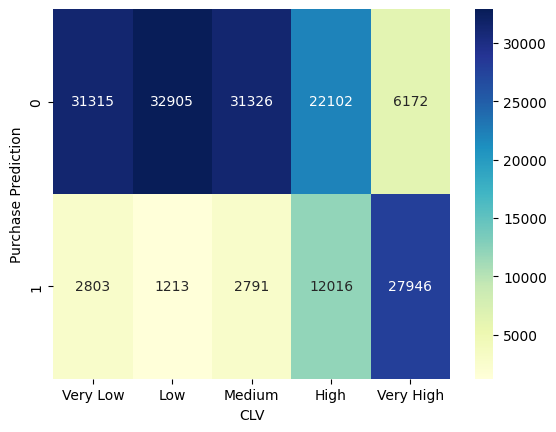

In [ ]:
# prompt: Plot a HeatMap of the columns CLV and purchase_prediction
# Create a crosstab table of CLV and purchase_prediction
ct = pd.crosstab( client['purchase_prediction'],client['CLV'])

# Create a heatmap of the crosstab table
sns.heatmap(ct, annot=True, cmap="YlGnBu", fmt=".0f")
plt.ylabel("Purchase Prediction")
plt.xlabel("CLV")
plt.show()


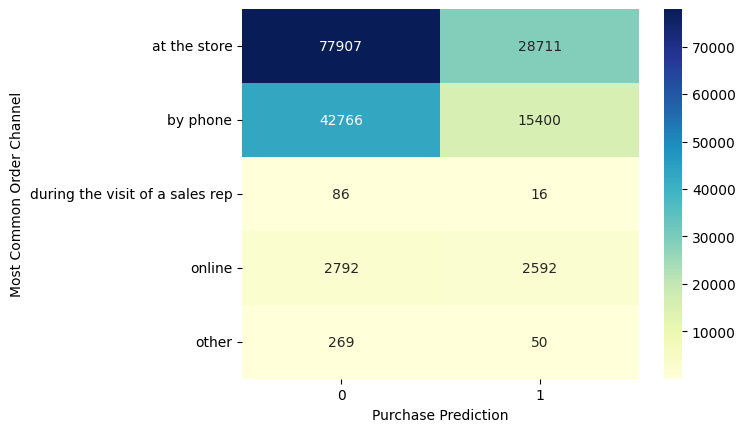

In [ ]:
# prompt: Plot a heatmap with the columns CLV and most_common_order_channel
# Create a crosstab table of CLV and most_common_order_channel
ct = pd.crosstab( client['most_common_order_channel'],client['purchase_prediction'])

# Create a heatmap of the crosstab table
sns.heatmap(ct, annot=True, cmap="YlGnBu", fmt=".0f")
plt.ylabel("Most Common Order Channel")
plt.xlabel("Purchase Prediction")
plt.show()
